<div style="text-align:center"> 
    <p style="font-size: 50px; margin-bottom: 0">Chemical Cartography</p>
    <p style="font-size: 20px; font-style: italic">ASTR 511 HW3 - Tom Wagg</p>
    <p>(glad we're continuing the theme of c alliteration in these titles haha)</p>
</div>

In [78]:
from astropy.table import Table

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("dark_background")

%config InlineBackend.figure_format = "retina"

# Part 1

## 1.1: The Data

In [9]:
dat = Table.read('allStarLite-dr17-synspec_rev1.fits', format='fits', hdu=1)

In [82]:
f'In this dataset there {len(dat)} stars each with {len(dat.columns)} columns - some of which are themselves multidimensional!!'

'In this dataset there 733901 stars each with 191 columns - some of which are themselves multidimensional!!'

My approximate reaction to this:
![](danger.gif)

In [83]:
# drop the multidimensional columns, switch to Pandas because why not and drop the NaNs
names = [name for name in dat.colnames if len(dat[name].shape) <= 1]
df = dat[names].to_pandas()
df = df.dropna(subset=["ALPHA_M", "FE_H"])

## 1.2: Wallerstein-Tinsley Diagram

Here are some simple polygons for the discs, I just did these roughly by eye when looking at the plots.

In [88]:
low_alpha_path = mpl.path.Path(
    np.array([
        [-0.5, 0.15],
        [-0.6, 0.15],
        [-0.8, 0.1],
        [-0.7, 0.05],
        [-0.6, 0.03],
        [0, -0.07],
        [0.55, -0.07],
        [0.58, 0.05],
        [0.2, 0.05],
        [-0.5, 0.15]
    ])
)
high_alpha_path = mpl.path.Path(
    np.array([
        [0.4, 0.05],
        [0.2, 0.05],
        [-0.5, 0.15],
        [-1, 0.23],
        [-1.3, 0.28],
        [-1.3, 0.35],
        [0, 0.36],
        [0.4, 0.05]
    ])
)

low_alpha_mask = low_alpha_path.contains_points(np.stack((df['M_H'], df['ALPHA_M'])).T)
high_alpha_mask = high_alpha_path.contains_points(np.stack((df['M_H'], df['ALPHA_M'])).T)

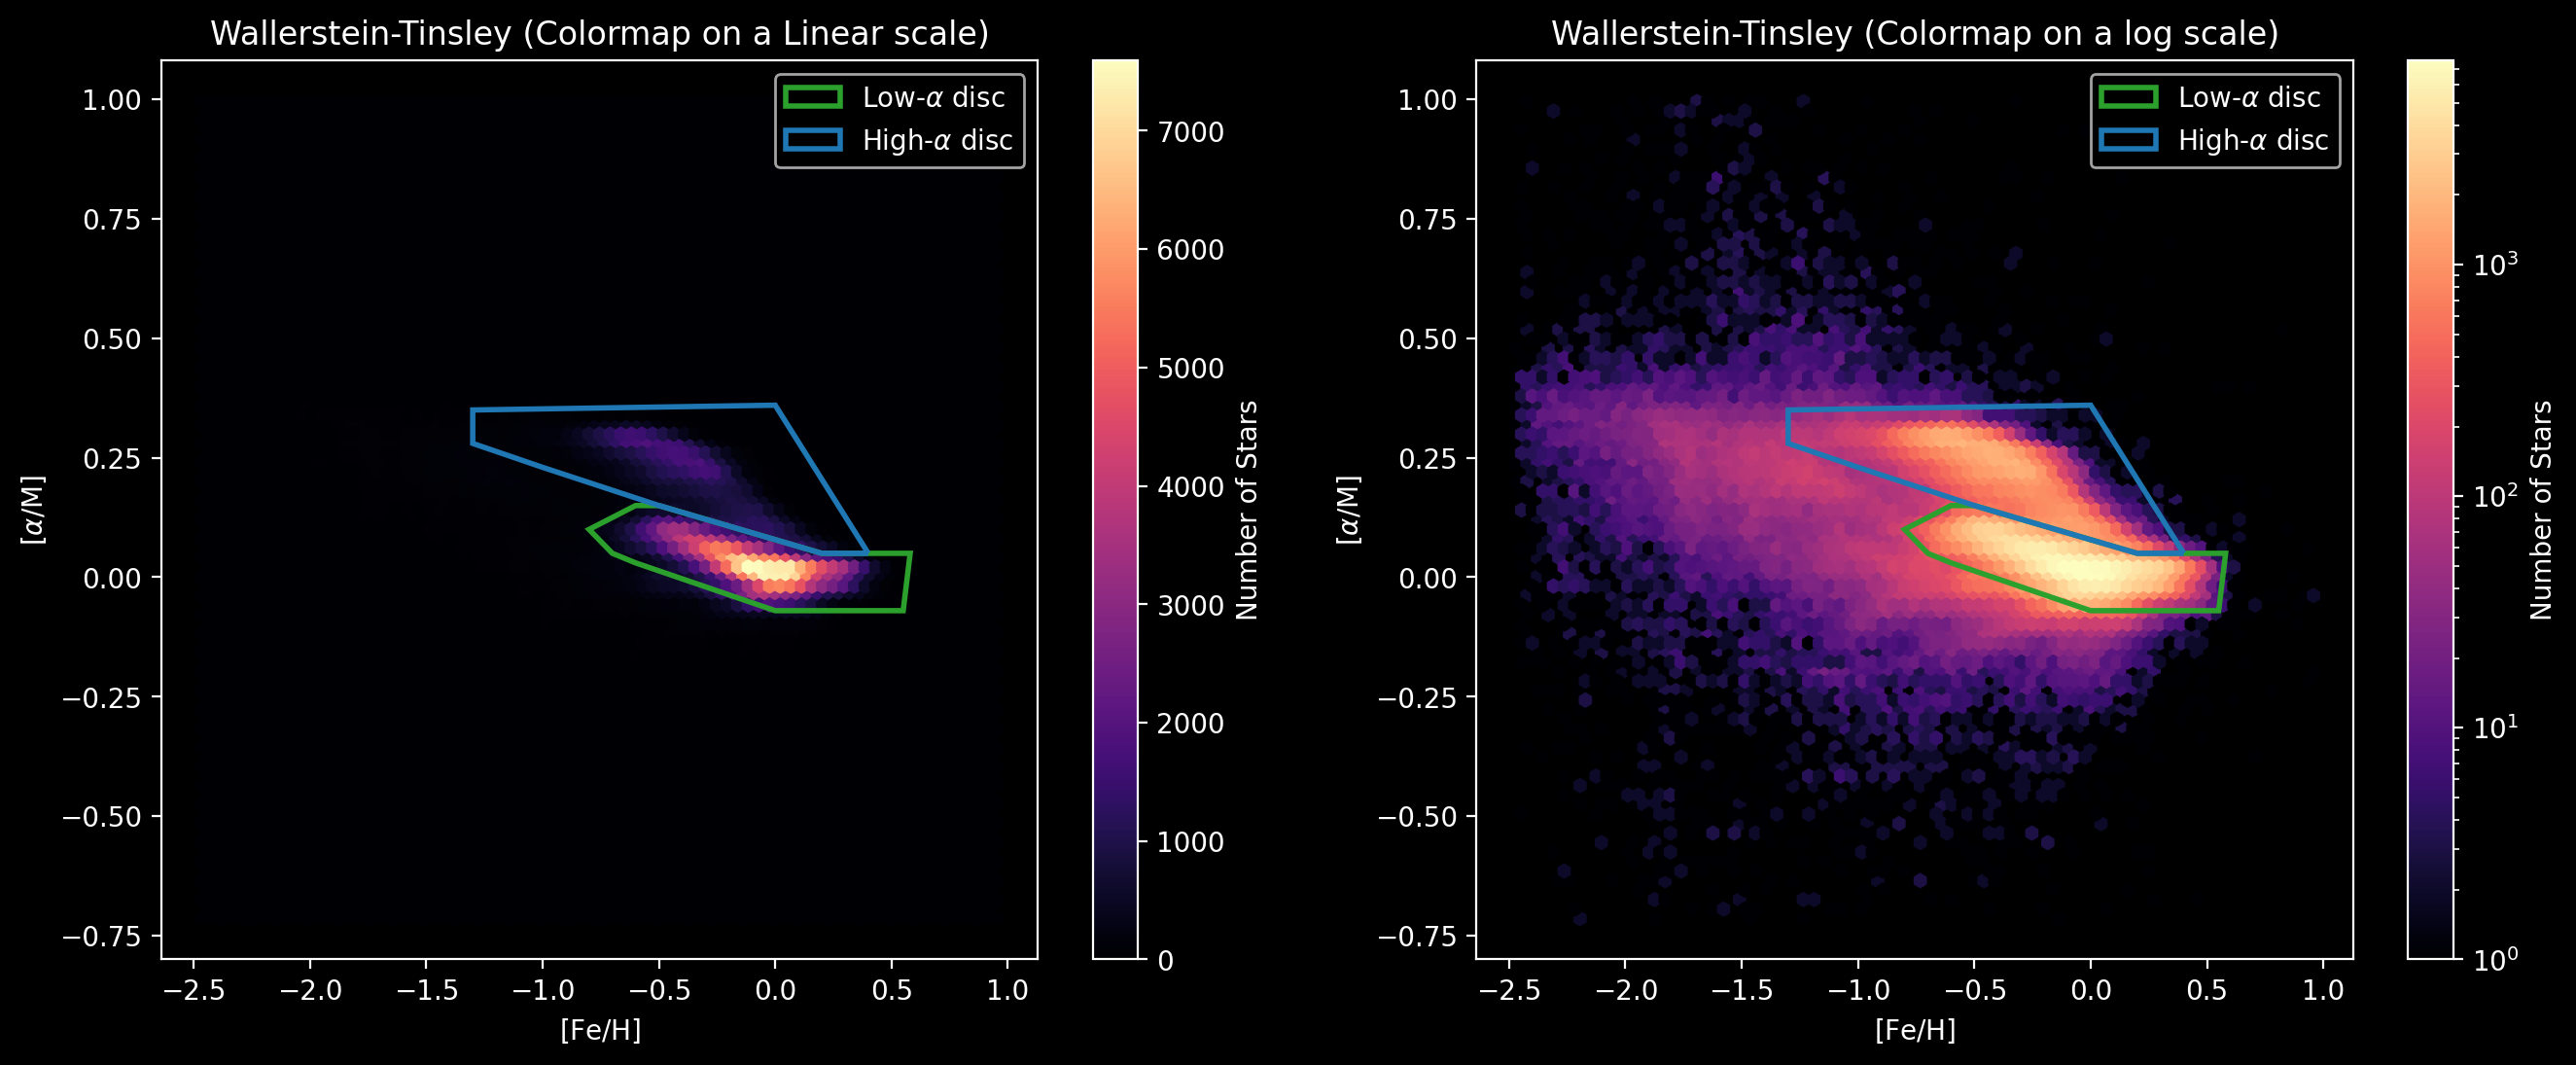

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, scale in zip(axes, [None, "log"]):
    hexbin = ax.hexbin(df["FE_H"], df["ALPHA_M"], cmap="magma", bins=scale, gridsize=75)

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                   ["tab:green", "tab:blue"],
                                   [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    fig.colorbar(hexbin, label="Number of Stars", ax=ax)

    if scale is None:
        scale = "Linear"
    ax.set_title(f"Wallerstein-Tinsley (Colormap on a {scale} scale)")

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.legend()

plt.show()


## 1.3: Dwarfs vs. Giants 

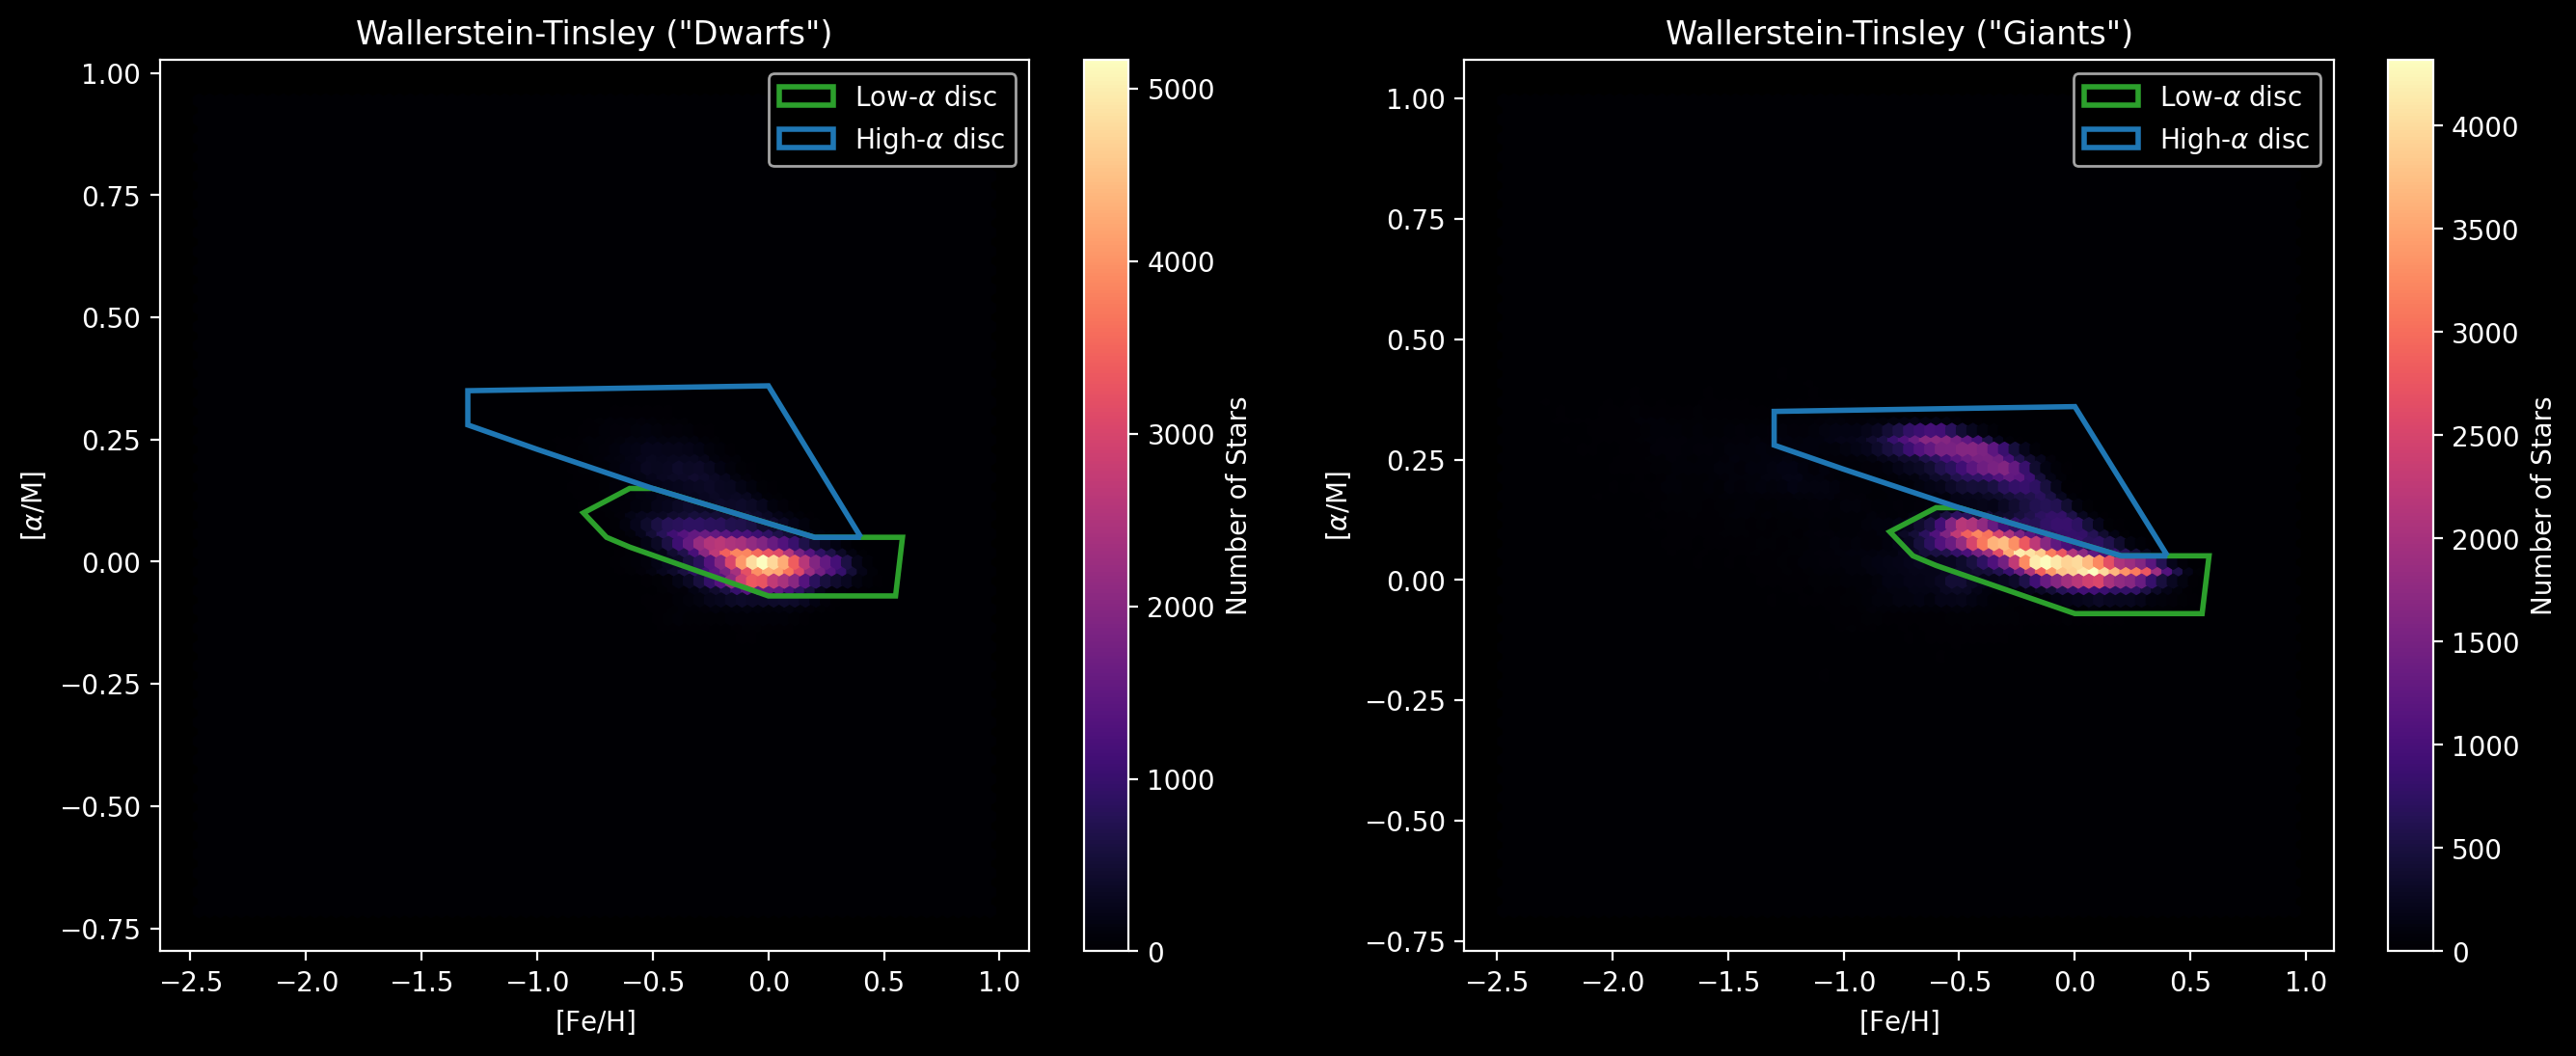

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, mask, title in zip(axes, [df["LOGG"] >= 3.5, df["LOGG"] < 3.5], ["Dwarfs", "Giants"]):
    hexbin = ax.hexbin(df["FE_H"][mask], df["ALPHA_M"][mask], cmap="magma", bins=None, gridsize=75)

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                   ["tab:green", "tab:blue"],
                                   [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    fig.colorbar(hexbin, label="Number of Stars", ax=ax)

    if scale is None:
        scale = "Linear"
    ax.set_title(f'Wallerstein-Tinsley (\"{title}\")')

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.legend()

plt.show()


So it looks to me like both discs are present for the Giants, but we can only see thin disc for the Dwarfs!